# Part 2: Data Selection and Engineering

#### Author: Ali Eddeb

In this notebook, I will be loading the cleaned Amazon review dataset for the beauty product category. The goal of this notebook is to explore the data and determine what are important features that can help determine fake reviews, including features that can be engineered.

In [25]:
#importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing the functions library that I created that includes the function that cleans the data
import functions_library as fl

In [3]:
#let's load in our dataset and apply the cleaning steps outlined in the previous notebook
file = 'All_Beauty.json.gz'
df = fl.cleanDF(fl.createPdDF(file))

In [4]:
#make sure df was loaded in correctly
df.tail()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,vote
362247,1,1,2017-07-20,A202DCI7TV1022,B01HJEGTYK,Sam,It was awful. It was super frizzy and I tried ...,It was super frizzy and I tried to comb it and...,0
362248,5,1,2017-03-16,A3FSOR5IJOFIBE,B01HJEGTYK,TYW,I was skeptical about buying this. Worried it...,Awesome,34
362249,5,1,2017-03-01,A1B5DK6CTP2P24,B01HJEGTYK,Norma Jennings,Makes me look good fast.,Five Stars,46
362250,2,1,2017-02-21,A23OUYS5IRMJS9,B01HJEGTYK,Lee,Way lighter than photo\nNot mix blend of color...,Ok but color way off and volume as well,0
362251,2,1,2016-12-15,A24KQ9RVU81L87,B01HJEGTYK,Season341,No return instructions/phone # in packaging. ...,Might return for a replacement if I could.,0


## 1. Features
Let's begin by determining, from the existing features, what should be included for modelling.

In [5]:
#what are the features?
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'vote'],
      dtype='object')

##### Let's go through each feature and determine if it is relevant to the problem. Additionally, let's determine if there are features that can be engineered from the existing features.

1. **Overall** - this is an important feature. This feature represents the rating the customer gave to the product. This is helpful as we expect fake reviews to either have a rating of 5 (highest rating) or 1 (lowest rating). **keep feature**

2. **Verified** - represents whether or not the review is associated with a verified purchase of the product. This is another important feature as we may see more unverified purchases related to fake negative reviews. **keep feature**

3. **reviewTime** - represents the date the review was published on Amazon. When performing exploration (in the next notebook), we can use this date tp look at some trends over time. There is an issue: models can only be built on numeric features and so, we cannot use this feature as it is a date. To remedy this, we can extract cyclical components of the date, which can be represented numerically, and include them for modelling. E.g. month  **remove feature but create new features based on the cyclical components of the date**

4. **reviewerID** - represents a unique ID for the customer that is submitting the review. Given this is a string variable, we cannot use this feature directly. However, we can look at behavioural patterns of reviewers and then encode them numerically; this will require some data exploration. **remove feature but explore reviewer behaviours that can be used to engineer features**

5. **asin** - represents a unique ID for the product that is being reviewed. Like reviewerID, this is a string variable and so, we cannot use this feature directly. However, we could look at product features (e.g. is it a brand name product) that can be encoded numerically. Again, this will require some data exploration. **remove feature but explore product features that can be used to engineer features**

6. **reviewerName** - represents the customer's name. This is a string variable and cannot be used directly for modelling. Recall, there were some reviewers that included there and some that did not and they were referred to as 'Amazon Customer'. There are 2 options here: 1) tokenize the names or 2) convert this feature to binary in which the decision criterion is whether or not their name is included. Will require some exploration to figure which option to go with. **convert this feature to binary or tokenize**

7. **reviewText** - represents the customer's review. This is one of the most important features in the data. The goal here would be to tokenize the text in the review in order to use it for modelling. Can also get a word count. **tokenize feature and get word count**

8. **summary** - the title for the review which is also submitted by the customer. Although the text in the summary field may be similar to that of the review, it may give us some insight into what a fake review looks like. Can also get a word count. **tokenize feature and get word count**

9. **vote** - represents the number of votes from other people that found the review helpful. This can be a useful feature and it is numeric. **keep feature**

## 2. Feature Selection and Engineering
From the section above, we can break down the features as follows:
1. Features to keep:\
Overall, Verified, Vote
2. Features that can have components extracted but the original feature will be omitted:\
reviewTime, reviewerID, asin
3. Feature that require some sort of manipulation in order to be used:\
reviewerName, reviewText, summary

Let's go through each of these groups of features and explore what adjustments are to be performed (if necessary).

### 2.1 Features to Keep 
##### Overall, Verified, Vote
For these features, they are already in a numeric format and can be used directly for modelling. No adjustments are necessary.

### 2.2 Features that can have components extracted but the original feature will be omitted:
##### reviewTime, reviewerID, asin

#### 2.2.1 reviewTime
For review time, we can extract the cyclical components of the date. 

##### New features: Month and Day of Week

I plan on extracting the **month** and the **day of the week**.
This can be done as follows:
```python
#get the month the review was posted in
dataframe['month'] = pd.DatetimeIndex(dataframe['reviewTime']).month

#get the day of the week the review was posted as an integer (Monday=0,Sunday=6)
dataframe['dayofweek'] = pd.DatetimeIndex(dataframe['reviewTime']).dayofweek
```
Then the reviewTime feature can be omitted as it is a datetime feature which cannot be used for modelling.

#### 2.2.2 reviewerID
We can look at behavioural patterns of reviewers and then encode their behaviour numerically. This will require some data exploration.

In [14]:
#let's first see how many reviews are posted per reviewer
df["reviewerID"].value_counts()

A2GJX2KCUSR0EI    25
A1KSC91G9AIY2Z    22
A1EGCED01USBA9    21
AENH50GW3OKDA     20
A22CW0ZHY3NJH8    20
                  ..
A18CX344FM8P2P     1
A2TAYRXDIX33QO     1
A4VUF5N4M4RK4      1
A7KPWIWSQ9LF0      1
A26S1RZJDHUHR4     1
Name: reviewerID, Length: 323687, dtype: int64

In [17]:
#let's get a better understanding by looking at the number of reviews per reviewer as quantiles
np.quantile(df['reviewerID'].value_counts().values, np.arange(0,1.05,0.05)).astype(int)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2, 25])

As we can see here, up to the 90th percentile, reviewers only gave 1 review. This feature seemingly would not be a good candidate for inclusion when modelling. However, I will include it on the basis that I will make improvements to the model in future iterations.

##### New feature: Multiple reviews per reviewer (True/False represented in binary)

```python
    #creating feature that indicates whether each review is the only review a reviewer has posted or 
    #if they have posted other reviews as well (no=0, yes=1)
    #1. start by getting a dictionary of the number of reviews per unique reviewer
    map_numreviews = dataframe['reviewerID'].value_counts().to_dict()
    #2. map the dictionary above to the reviewers in the dataframe and create a new column from this
    dataframe['multipleReviews_reviewer'] = dataframe['reviewerID'].map(map_numreviews)
    #3. finally, convert the number of reviews to binary: 1 review = 0; more than 1 review = 1
    dataframe['multipleReviews_reviewer'] = np.where(dataframe['multipleReviews_reviewer'] > 1, 1, 0)
```

Now, let's look at voting patterns of reviewers.

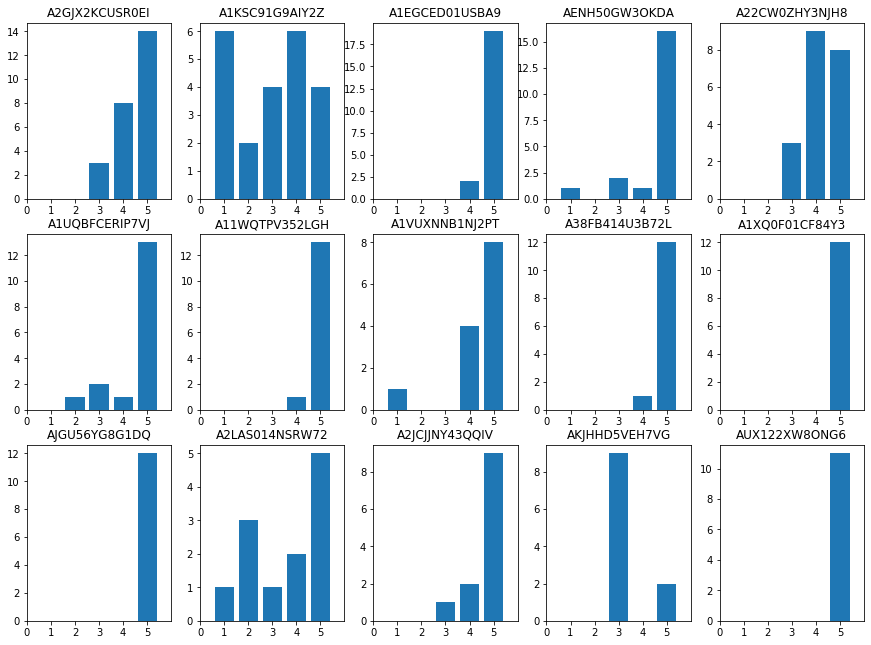

In [18]:
plt.subplots(3,5, figsize=(15,11))

for i in range(0,15):
    #get reviewers ID
    reviewer = df["reviewerID"].value_counts().index[i]
    #get value counts for each reviewer (the overall rating they give with each review)
    data = df['overall'][df['reviewerID'] == reviewer].value_counts()
    
    #now let's look at a couple different reviewers and their rating pattern
    plt.subplot(3,5,i+1)
    plt.bar(data.index, data.values)
    plt.title(reviewer)
    plt.xlim(0,6)
    plt.xticks(range(6))
plt.show()

Based on the above, we can highlight the following **types of reviewers:**
1. A bit of everything
- Mostly 5
- evenly distributed
2. 3, 4 and 5 but mostly 5
3. Mainly 5 with few 4 scores
4. Only 5

The most suspicious group of reviewers is the fourth group that only gave 5 star reviews. This group could potentially incentivized to give these 5 star reviews but there is still a large chance that these are genuine reviewers.

Now, we don't observe the opposite behaviour, reviewers only giving 1 star ratings. I surmise that if a business is going to try and undercut their competitor(s), they would want to give many 1 star ratings but to do so, they would need to use multiple accounts. For that reason, we would not expect to see reviewers with many 1 star reviews, rather there would be more reviewers with just 1 1-star review. Let's check out the data to see if this hypothesis holds up.

Let's use the code created above to create a binary feature for reviews per reviewer. If the reviewer had posted more than 1 review, then this new feature will be equal to 1 (ie. True), but it they only posted one review, then this feature will be equal to 0 (ie. false).

In [24]:
#creating feature that indicates whether each review is the only review a reviewer has posted or if the reviewer has posted other 
#reviews as well (no=0, yes=1)

#1. start by getting a dictionary of the number of reviews per unique reviewer
map_numreviews = df['reviewerID'].value_counts().to_dict()
#2. map the dictionary above to the reviewers in the dataframe and create a new column from this
df['multipleReviews_reviewer'] = df['reviewerID'].map(map_numreviews)
#3. finally, convert the number of reviews to binary: 1 review = 0; more than 1 review = 1
df['multipleReviews_reviewer'] = np.where(df['multipleReviews_reviewer'] > 1, 1, 0)

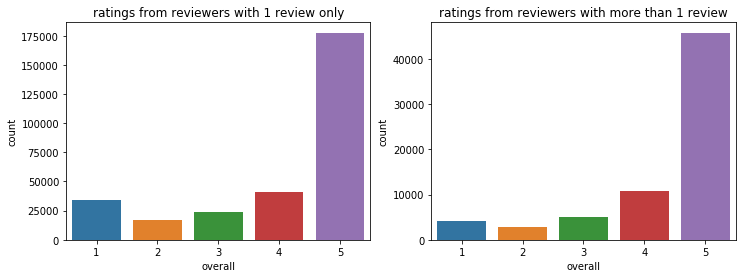

In [27]:
plt.subplots(1,2, figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x='overall', data=df[df['multipleReviews_reviewer']==0])
plt.title('ratings from reviewers with 1 review only')

plt.subplot(1,2,2)
sns.countplot(x='overall', data=df[df['multipleReviews_reviewer']==1])
plt.title('ratings from reviewers with more than 1 review')

plt.show()

As we can see, the proportion of 1-star reviews is higher from reviewers that only posted 1 review compared to reviewers that posted more than 1 review. This gives some credence to my assumption that if a business is going to try and undercut their competitor(s), they would want to give many 1 star ratings but to do so, they would need to use multiple accounts. For that reason, we would not expect to see reviewers with many 1 star reviews, rather there would be more reviewers with just 1 1-star review.

From this, we can create 2 new features. Whether a reviewer only posted 1) 5-star reviews or 2) 1-star reviews. Then we can match this with the other feature, multipleReviews_reviewer, to get an overall sense of reviewer behaviour. 

##### New Features: 1) Reviewer 5 Star Only & 2) Reviewer 1 Star Only 
Both are True/False represented in binary

Here is the code to create the new features:

```python
    #create new features that display if a reviewer only gave 5 star reviews or one star reviews
    #1. need a dictionary of booleans which checks if they only have 5 or 1 star reviews
    map_five = dataframe['overall'].groupby(dataframe['reviewerID']).agg(lambda x: (np.unique(x)==5).all()).to_dict()
    map_one = dataframe['overall'].groupby(dataframe['reviewerID']).agg(lambda x: (np.unique(x)==1).all()).to_dict()
    #2. create new columns with mappings created above
    dataframe['reviewer_five_star_only'] = dataframe['reviewerID'].map(map_five)
    dataframe['reviewer_one_star_only'] = dataframe['reviewerID'].map(map_one)
    #3. convert booleans to binary
    dataframe['reviewer_five_star_only'] = dataframe['reviewer_five_star_only'].astype(int)
    dataframe['reviewer_one_star_only'] = dataframe['reviewer_one_star_only'].astype(int)
```

#### 2.2.3 Asin
Asin is just the unique product ID for the product being reviewed. The one feature we can extract is we can check how many reviews a certain product has. This can give us an indication of how popular a product is. The more reviews, the more popular. From this, we could see if more popular or less popular products tend to have more fake reviews.

##### New Feature: Number of Reviews per Product

This is the code to get the popularity of product based on the number of reviews:

```python
    #get number of reviews associated with each product (asin) - to be used as a popularity index
    #1. create a map of the number of reviews per product
    map_numreviews = dataframe['asin'].value_counts().to_dict()
    #2. map the dictionary to the asin (product IDs) and create a new column based off that
    dataframe['numReviews_product'] = dataframe['asin'].map(map_numreviews) 
```

### 2.3 Feature that require some sort of manipulation in order to be used
##### reviewerName, reviewText, summary

#### 2.3.1 reviewerName
There are a lot of unique customer names. However, as we have seen before, there were unnamed customers - there names were simply listed as 'Amazon Customer'.
Thus, we can convert reviewerName to a new feature which checks if someone has listed their name or not.

Here is the code to do so.

```python
#checking if customer provided their name or not (binary)
#if the customer's name is NOT 'Amazon Customer', then nameProvided = True (ie. 1). Otherwise, False.
dataframe['nameProvided'] = np.where(dataframe['reviewerName'] != 'Amazon Customer',1,0)
```

##### 2.3.2/3 reviewText and summary
We can treat these 2 features similarly. Both features contain text. We can tokenize the text in each feature, which I will do in a later notebook. However, for now, we create another feature which is word count. We can get word counts for both the reviewText and summary fields.

##### New Features: Word Counts

Here is the code to get the word counts for each:

```python
#getting word counts for review and summary columns
dataframe['review_word_count'] = dataframe['reviewText'].str.split().str.len()
dataframe['summary_word_count'] = dataframe['summary'].str.split().str.len()
```

## Final function for Feature Engineering
Now that we have gone through and created all the new features and made adjustments to the existing features, we can aggregate all the changes made into a new function for future use. Here is the function, named featureEngin:

In [ ]:
def featureEngin(dataframe):
    '''
    This functions create several new features and adds them to the dataframe that is passed through as the argument.
    
    New features:
    
    1. Adds review word count and summary word count to the DataFrame.
    
    2. Extracts the cyclical components of the date and creates a column for each.
    The cyclical componenets are month(1-12) and day of week(0-6).  
    
    3. Creating feature that indicates whether each review is the only review a reviewer has posted or if they have posted other reviews as well (no=0, yes=1)
    
    4. Create new features that display if a reviewer only gave 5 star reviews or one star reviews (both are binary features)
    
    5. Get number of reviews associated with each product (asin) to be used as a popularity index

    6. Checking if customer provided their name or not (binary)

    Returns original dataframe that was passed in with these new features listed above.
    '''
    #adding word counts for review and summary columns
    dataframe['review_word_count'] = dataframe['reviewText'].str.split().str.len()
    dataframe['summary_word_count'] = dataframe['summary'].str.split().str.len()
    
    #get the month the review was posted in
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html
    dataframe['month'] = pd.DatetimeIndex(dataframe['reviewTime']).month

    #get the day of the week the review was posted as an integer (Monday=0,Sunday=6)
    dataframe['dayofweek'] = pd.DatetimeIndex(dataframe['reviewTime']).dayofweek
    
    #creating feature that indicates whether each review is the only review a reviewer has posted or 
    #if they have posted other reviews as well (no=0, yes=1)
    #1. start by getting a dictionary of the number of reviews per unique reviewer
    map_numreviews = dataframe['reviewerID'].value_counts().to_dict()
    #2. map the dictionary above to the reviewers in the dataframe and create a new column from this
    dataframe['multipleReviews_reviewer'] = dataframe['reviewerID'].map(map_numreviews)
    #3. finally, convert the number of reviews to binary: 1 review = 0; more than 1 review = 1
    dataframe['multipleReviews_reviewer'] = np.where(dataframe['multipleReviews_reviewer'] > 1, 1, 0)
    
    #create new features that display if a reviewer only gave 5 star reviews or one star reviews
    #1. need a dictionary of booleans which checks if they only have 5 or 1 star reviews
    map_five = dataframe['overall'].groupby(dataframe['reviewerID']).agg(lambda x: (np.unique(x)==5).all()).to_dict()
    map_one = dataframe['overall'].groupby(dataframe['reviewerID']).agg(lambda x: (np.unique(x)==1).all()).to_dict()
    #2. create new columns with mappings created above
    dataframe['reviewer_five_star_only'] = dataframe['reviewerID'].map(map_five)
    dataframe['reviewer_one_star_only'] = dataframe['reviewerID'].map(map_one)
    #3. convert booleans to binary
    dataframe['reviewer_five_star_only'] = dataframe['reviewer_five_star_only'].astype(int)
    dataframe['reviewer_one_star_only'] = dataframe['reviewer_one_star_only'].astype(int)

    #get number of reviews associated with each product (asin) - to be used as a popularity index
    #1. create a map of the number of reviews per product
    map_numreviews = dataframe['asin'].value_counts().to_dict()
    #2. map the dictionary to the asin (product IDs) and create a new column based off that
    dataframe['numReviews_product'] = dataframe['asin'].map(map_numreviews) 
    
    #checking if customer provided their name or not (binary)
    dataframe['nameProvided'] = np.where(dataframe['reviewerName'] != 'Amazon Customer',1,0)

    return dataframe

Now proceed to the next notebook (data exploration).